In [1]:
import sys
from docplex.cp.model import *

# Scheduling problem to be solved

In [2]:
MaxNoOfChannel = 4
EventNames = {"Break-Fail","Accident","Jaywalking","Pedestrian-Crossing","Yellow-Light"}
Duration =  [30, 15, 35, 15, 15]
AverageTransmissionTime =  [35, 40, 45, 40, 35]
NoOfSituations  = 5
SituationArrivalTime = [0, 50, 100, 150, 200]

In [3]:
mdl4 = CpoModel()

In [4]:
Situations = range(NoOfSituations)

In [5]:
itvs = {}
for h in Situations:
    for i,t in enumerate(EventNames):
        itvs[h,t] = mdl4.interval_var(start = [SituationArrivalTime[h], INTERVAL_MAX], size=Duration[i])

# Defining Event Precedences

In [6]:
Precedences = [("Break-Fail", "Accident"), ("Break-Fail", "Jaywalking"), ("Break-Fail", "Pedestrian-Crossing"),
               ("Accident", "Pedestrian-Crossing"), ("Accident", "Yellow-Light")]

In [7]:
channel_usage = step_at(0, 0)
for h in Situations:
    for t in EventNames:
        channel_usage += mdl4.pulse(itvs[h,t],1)

In [8]:
cash = step_at(0, 0)
for p in Situations:
    cash += mdl4.step_at(60*p, 30000)

for h in Situations:
    for i,t in enumerate(EventNames):
        cash -= mdl4.step_at_start(itvs[h,t], 200*Duration[i])

In [9]:
for h in Situations:
    for p in Precedences:
        mdl4.add( mdl4.end_before_start(itvs[h,p[0]], itvs[h,p[1]]) )

In [10]:
mdl4.add( channel_usage <= MaxNoOfChannel )

In [11]:
mdl4.add( cash >= 0 )

In [12]:
mdl4.add(
    mdl4.minimize( 
        mdl4.max( mdl4.end_of(itvs[h,"Yellow-Light"]) for h in Situations)
    )
)

# Solve the model

In [13]:
print("\nSolving model....")
msol4 = mdl4.solve(FailLimit=30000)
print("done")


Solving model....
C:/Users/nayre/AppData/Local/Temp/ipykernel_15816/1349103155.py:1(stream:64:1): Warning: Cumulative expression 'stepAt': height is zero, expression is zero everywhere.
                                                                                           stepAt(0, 0)
C:/Users/nayre/AppData/Local/Temp/ipykernel_15816/1131574978.py:1(stream:66:1): Warning: Cumulative expression 'stepAt': height is zero, expression is zero everywhere.
                                                                                           stepAt(0, 0)
 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 25 variables, 27 constraints
 ! FailLimit            = 30000
 ! Initial process time : 0.02s (0.02s extraction + 0.00s propagation)
 !  . Log search space  : 116.1 (before), 116.1 (after)
 !  . Memory usage      : 763.7 kB (before), 763.7 kB (after)
 ! Using parallel search with 16 workers.
 ! ------------------------------------

In [14]:
print("Utilization will be " + str( msol4.get_objective_values()[0] ))

Utilization will be 260


# Visualization

In [15]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

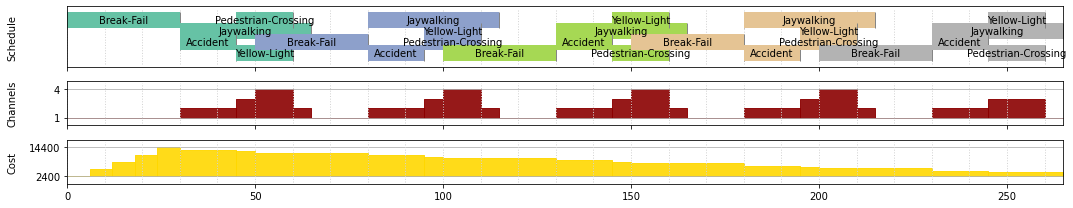

In [16]:
workersF = CpoStepFunction()
cashF = CpoStepFunction()
for p in range(5):
    cashF.add_value(6 * p, INT_MAX, 3000)
for h in Situations:
    for i,t in enumerate(EventNames):
        itv = msol4.get_var_solution(itvs[h,t])
        workersF.add_value(itv.get_start(), itv.get_end(), 1)
        cashF.add_value(itv.start, INT_MAX, -20 * Duration[i])

visu.timeline('Solution SchedCumul')
visu.panel(name="Schedule")
for h in Situations:
    for i,t in enumerate(EventNames):
        visu.interval(msol4.get_var_solution(itvs[h,t]), h, t)
visu.panel(name="Channels")
visu.function(segments=workersF, style='area')
visu.panel(name="Cost")
visu.function(segments=cashF, style='area', color='gold')
visu.show()